# Task
Train an SRGAN model using the image data located in the "midterm data" folder on Google Drive.

## Mount google drive

### Subtask:
Mount Google Drive to access the data.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

folder_path = '/content/drive/MyDrive/midterm/data'

if os.path.exists(folder_path):
    print(f"The folder '{folder_path}' is accessible.")
    print("Contents of the folder:")
    for item in os.listdir(folder_path):
        print(item)
else:
    print(f"The folder '{folder_path}' was not found.")

The folder '/content/drive/MyDrive/midterm/data' is accessible.
Contents of the folder:
lowres_32
processed_128
test


## Load and preprocess data

### Subtask:
Load the images from the specified folder and preprocess them for training the SRGAN model. This may include resizing, normalization, and splitting into training and validation sets.


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from sklearn.model_selection import train_test_split

lowres_dir = '/content/drive/MyDrive/midterm/data/lowres_32'
highres_dir = '/content/drive/MyDrive/midterm/data/processed_128'

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8851990896612264720
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 40419328000
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7862830018547058693
physical_device_desc: "device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0"
xla_global_id: 416903419
]


## Load and preprocess data

### Subtask:
Load the images from the specified folder and preprocess them for training the SRGAN model. This may include resizing, normalization, and splitting into training and validation sets.


In [4]:
# Configuration - align with your assignment requirements
LR_SHAPE = (32, 32, 3)    # Low-resolution input
HR_SHAPE = (128, 128, 3)  # High-resolution target
SCALING_FACTOR = 4         # 4x upscaling (32→128)
BATCH_SIZE = 32
EPOCHS = 150

In [5]:
def load_and_preprocess_images():

    # Load without batching first
    highres_ds = tf.keras.preprocessing.image_dataset_from_directory(
        '/content/drive/MyDrive/midterm/data/processed_128',
        labels=None,
        image_size=(128, 128),
        batch_size=None,  # No batching initially
        shuffle=True,
        seed=123,
    )

    def create_hr_lr_pair(hr_img):
        # Normalize to [-1, 1]
        hr_img = tf.cast(hr_img, tf.float32)
        hr_img = (hr_img / 127.5) - 1.0

        # Create low-res version
        lr_img = tf.image.resize(hr_img, [32, 32], method='area')

        return lr_img, hr_img

    # Create paired dataset
    paired_ds = highres_ds.map(create_hr_lr_pair, num_parallel_calls=tf.data.AUTOTUNE)

    # Apply batching ONLY ONCE
    paired_ds = paired_ds.batch(BATCH_SIZE)  # Batch size 32

    # Get dataset info
    dataset_size = 25000  # Count unbatched elements
    train_size = 17500

    print(f"Total samples: {dataset_size}")
    print(f"Training samples: {train_size}")
    print(f"Test samples: {dataset_size - train_size}")

    # Split dataset
    train_ds = paired_ds.take(train_size)
    test_ds = paired_ds.skip(train_size)

    # Prefetch for performance
    train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
    test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

    return train_ds, test_ds

# Test the fix
print("Creating dataset...")
train_ds, test_ds = load_and_preprocess_images()

def verify_fixed_shapes(dataset, name="Dataset"):
    """Verify the dataset shapes"""
    print(f"\n{name} Shape Verification:")
    for hr_batch, lr_batch in dataset.take(1):
        print(f"HR batch shape: {hr_batch.shape}")
        print(f"LR batch shape: {lr_batch.shape}")

        # Check individual sample shapes
        print(f"HR sample shape: {hr_batch[0].shape}")
        print(f"LR sample shape: {lr_batch[0].shape}")

        # Check value ranges
        print(f"HR value range: [{tf.reduce_min(hr_batch[0]):.3f}, {tf.reduce_max(hr_batch[0]):.3f}]")
        print(f"LR value range: [{tf.reduce_min(lr_batch[0]):.3f}, {tf.reduce_max(lr_batch[0]):.3f}]")
        break

verify_fixed_shapes(train_ds, "Training")

Creating dataset...
Found 25000 files.
Total samples: 25000
Training samples: 17500
Test samples: 7500

Training Shape Verification:
HR batch shape: (32, 32, 32, 3)
LR batch shape: (32, 128, 128, 3)
HR sample shape: (32, 32, 3)
LR sample shape: (128, 128, 3)
HR value range: [-1.000, 0.913]
LR value range: [-1.000, 1.000]


In [ ]:
# Verify your normalization
def verify_normalization(dataset):
    for lr_batch, hr_batch in dataset.take(1):
        print(f"LR range: [{tf.reduce_min(lr_batch):.3f}, {tf.reduce_max(lr_batch):.3f}]")
        print(f"HR range: [{tf.reduce_min(hr_batch):.3f}, {tf.reduce_max(hr_batch):.3f}]")

verify_normalization(train_ds)

LR range: [-1.000, 1.000]
HR range: [-1.000, 1.000]


In [6]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, PReLU, Add, UpSampling2D, Dense, Flatten, LeakyReLU

# Define the generator model (based on the SRResNet architecture)
def build_generator(input_shape):
    def residual_block(x):
        filters = 64
        kernel_size = 3
        strides = 1
        padding = 'same'
        gamma_init = tf.random_normal_initializer(1., 0.02)

        y = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding)(x)
        y = BatchNormalization(gamma_initializer=gamma_init)(y)
        y = PReLU(shared_axes=[1, 2])(y)
        y = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding)(y)
        y = BatchNormalization(gamma_initializer=gamma_init)(y)
        out = Add()([x, y])
        return out

    def upscale_block(x):
        filters = 256
        kernel_size = 3
        strides = 1
        padding = 'same'

        y = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding)(x)
        y = UpSampling2D(size=2)(y)
        y = PReLU(shared_axes=[1, 2])(y)
        return y

    inputs = Input(shape=input_shape)

    # Initial convolutional layer
    x = Conv2D(filters=64, kernel_size=9, strides=1, padding='same')(inputs)
    x = PReLU(shared_axes=[1, 2])(x)

    # Residual blocks
    for _ in range(16): # As in the original SRResNet paper
        x = residual_block(x)

    # Second convolutional layer with skip connection
    x = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x, Conv2D(filters=64, kernel_size=9, strides=1, padding='same')(inputs)]) # Add skip connection from initial layer

    # Upscaling blocks
    x = upscale_block(x)
    x = upscale_block(x)

    # Output convolutional layer
    outputs = Conv2D(filters=3, kernel_size=9, strides=1, padding='same', activation='tanh')(x)

    generator = Model(inputs=inputs, outputs=outputs)
    print(f"Generator built: input {generator.input_shape}, output {generator.output_shape}")
    return generator

# Define the discriminator model
def build_discriminator(input_shape):
    def discriminator_block(x, filters, strides, batchnorm=True):
        x = Conv2D(filters=filters, kernel_size=3, strides=strides, padding='same')(x)
        if batchnorm:
            x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
        return x

    inputs = Input(shape=input_shape)

    x = discriminator_block(inputs, 64, 2, batchnorm=False)
    x = discriminator_block(x, 128, 2)
    x = discriminator_block(x, 256, 2)
    x = discriminator_block(x, 512, 2)
    x = discriminator_block(x, 512, 2)
    x = discriminator_block(x, 512, 2)
    x = discriminator_block(x, 1024, 1)
    x = discriminator_block(x, 1024, 1)


    x = Flatten()(x)
    x = Dense(1024)(x)
    x = LeakyReLU(alpha=0.2)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    discriminator = Model(inputs=inputs, outputs=outputs)
    print(f"Discriminator built: input {discriminator.input_shape}, output {discriminator.output_shape}")
    return discriminator

# Define the input shapes
lowres_shape = (32, 32, 3)
highres_shape = (128, 128, 3)

# Build the generator and discriminator models
generator = build_generator(lowres_shape)
discriminator = build_discriminator(highres_shape)

generator.summary()
discriminator.summary()

Generator built: input (None, 32, 32, 3), output (None, 128, 128, 3)
Discriminator built: input (None, 128, 128, 3), output (None, 1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │     15,616 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu (PReLU)     │ (None, 32, 32,    │         64 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │     36,928 │ p_re_lu[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_1 (PReLU)   │ (None, 32, 32,    │         64 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     36,928 │ p_re_lu_1[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ p_re_lu[0][0],    │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │     36,928 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_2 (PReLU)   │ (None, 32, 32,    │         64 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     36,928 │ p_re_lu_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 32, 32,    │          0 │ add[0][0],        │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ add_1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_5[0][0]  

 Total params: 2,059,907 (7.86 MB)

 Trainable params: 2,055,683 (7.84 MB)

 Non-trainable params: 4,224 (16.50 KB)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 2, 2, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 2, 2, 1024)     │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 2, 2, 1024)     │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 2, 2, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 2, 2, 1024)     │     9,438,20

 Total params: 24,640,641 (94.00 MB)

 Trainable params: 24,632,705 (93.97 MB)

 Non-trainable params: 7,936 (31.00 KB)

In [7]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
import keras
from tensorflow.keras.applications.vgg19 import preprocess_input # Import preprocess_input

# Define the combined SRGAN model as a Keras Model subclass
class SRGAN(keras.Model):
    def __init__(self, generator, discriminator, vgg):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.vgg = vgg # VGG model for perceptual loss

    def compile(self, generator_optimizer, discriminator_optimizer):
        super().compile()
        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer
        # Define loss functions here as well, matching the train_step
        self.adversarial_loss = keras.losses.BinaryCrossentropy(from_logits=False) # Use from_logits=False since discriminator output has sigmoid
        self.pixel_loss = keras.losses.MeanSquaredError()
        # perceptual_loss function is defined outside the class, using self.vgg

    def perceptual_loss(self, highres_true, highres_gen):
        # Cast to float32
        highres_true = tf.cast(highres_true, tf.float32)
        highres_gen = tf.cast(highres_gen, tf.float32)

        # Resize to VGG input (128x128) if necessary
        if highres_true.shape[1:3] != (128, 128):
            highres_true = tf.image.resize(highres_true, (128, 128))
        if highres_gen.shape[1:3] != (128, 128):
            highres_gen = tf.image.resize(highres_gen, (128, 128))

        # Scale from [-1,1] -> [0,255]
        highres_true = tf.clip_by_value((highres_true + 1.0) * 127.5, 0.0, 255.0)
        highres_gen = tf.clip_by_value((highres_gen + 1.0) * 127.5, 0.0, 255.0)

        # Preprocess for VGG
        highres_true_vgg = preprocess_input(highres_true)
        highres_gen_vgg = preprocess_input(highres_gen)

        # Compute MSE in feature space
        return tf.reduce_mean(tf.square(self.vgg(highres_true_vgg) - self.vgg(highres_gen_vgg)))


    @tf.function
    def train_step(self, data):
        lowres_images, highres_images = data

        # Train Discriminator (alternating updates - train discriminator half as often as generator)
        # This logic is handled outside this function in the training loop or dataset
        with tf.GradientTape() as tape:
            generated_highres_images = self.generator(lowres_images, training=False)
            real_output = self.discriminator(highres_images, training=True)
            fake_output = self.discriminator(generated_highres_images, training=True)

            # Use label smoothing for real and fake labels
            real_labels = tf.ones_like(real_output) * 0.9 # Smooth real labels to 0.9
            fake_labels = tf.zeros_like(fake_output) + 0.1 # Smooth fake labels to 0.1

            real_loss = tf.cast(self.adversarial_loss(real_labels, real_output), tf.float32)
            fake_loss = tf.cast(self.adversarial_loss(fake_labels, fake_output), tf.float32)
            discriminator_loss = (tf.reduce_mean(real_loss) + tf.reduce_mean(fake_loss))


            disc_gradients = tape.gradient(discriminator_loss, discriminator.trainable_variables)
            disc_gradients, _ = tf.clip_by_global_norm(disc_gradients, 5.0)
            self.discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

        # Train Generator
        with tf.GradientTape() as tape:
            generated_highres = self.generator(lowres_images, training=True)
            fake_output = self.discriminator(generated_highres, training=False)

            perc_loss = tf.cast(self.perceptual_loss(highres_images, generated_highres), tf.float32)
            pix_loss = tf.cast(self.pixel_loss(highres_images, generated_highres), tf.float32)
            gan_loss = tf.cast(self.adversarial_loss(tf.ones_like(fake_output), fake_output), tf.float32)

            perc_loss = tf.reduce_mean(perc_loss)
            pix_loss = tf.reduce_mean(pix_loss)

            generator_loss = 0.01 * perc_loss + 0.005 * gan_loss + 0.01 * pix_loss

            gen_gradients = tape.gradient(generator_loss, generator.trainable_variables)
            gen_gradients, _ = tf.clip_by_global_norm(gen_gradients, 5.0)
            self.generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))

        return {
            "discriminator_loss": discriminator_loss,
            "generator_loss": generator_loss,
            "perceptual_loss": perc_loss,
            "pixel_loss": pix_loss,
            "gan_loss": gan_loss
        }

    @tf.function
    def test_step(self, data):
        lowres_images, highres_images = data
        generated_highres = self.generator(lowres_images, training=False)

        real_output = self.discriminator(highres_images, training=False)
        fake_output = self.discriminator(generated_highres, training=False)

        real_loss = tf.cast(self.adversarial_loss(tf.ones_like(real_output), real_output), tf.float32)
        fake_loss = tf.cast(self.adversarial_loss(tf.zeros_like(fake_output), fake_output), tf.float32)
        discriminator_loss = real_loss + fake_loss

        perc_loss = tf.cast(self.perceptual_loss(highres_images, generated_highres), tf.float32)
        pix_loss = tf.cast(self.pixel_loss(highres_images, generated_highres), tf.float32)
        gan_loss = tf.cast(self.adversarial_loss(tf.ones_like(fake_output), fake_output), tf.float32)

        generator_loss = perc_loss + 1e-2 * gan_loss + 1e-2 * pix_loss

        return {
            "discriminator_loss": discriminator_loss,
            "generator_loss": generator_loss,
            "perceptual_loss": perc_loss,
            "pixel_loss": pix_loss,
            "gan_loss": gan_loss
        }


# Assuming generator and discriminator models are built in a previous cell
# Define the input shapes
lowres_shape = (32, 32, 3)
highres_shape = (128, 128, 3)

# Build the generator and discriminator models
# These lines should be in a previous cell, but are included here for completeness
# generator = build_generator(lowres_shape)
# discriminator = build_discriminator(highres_shape)

# Perceptual loss using VGG19
vgg = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
vgg.trainable = False
vgg_output_layer = vgg.get_layer('block5_conv4').output # Using the output of a specific VGG layer
vgg_model_for_loss = Model(inputs=vgg.input, outputs=vgg_output_layer)

# Instantiate the SRGAN model
srgan = SRGAN(generator=generator, discriminator=discriminator, vgg=vgg_model_for_loss)

# Define optimizers (as in article)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.5)
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5)

# Compile the model
srgan.compile(
     generator_optimizer=generator_optimizer,
     discriminator_optimizer=discriminator_optimizer
     # Losses are defined within the SRGAN class's compile method
 )

In [ ]:
import os
import tensorflow as tf
import keras

# Enable mixed precision training globally for speedup on compatible hardware
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Custom callback to save generator and discriminator weights
class CustomGANCheckpoint(keras.callbacks.Callback):
    def __init__(self, checkpoint_dir, gen_filename='generator_epoch_{epoch:03d}.weights.h5', disc_filename='discriminator_epoch_{epoch:03d}.weights.h5'):
        super().__init__()
        self.checkpoint_dir = checkpoint_dir
        self.gen_filename = gen_filename
        self.disc_filename = disc_filename

    def on_epoch_end(self, epoch, logs=None):
        # self.model here refers to the SRGAN instance being trained
        gen_path = os.path.join(self.checkpoint_dir, self.gen_filename.format(epoch=epoch + 1))
        disc_path = os.path.join(self.checkpoint_dir, self.disc_filename.format(epoch=epoch + 1))

        self.model.generator.save_weights(gen_path)
        self.model.discriminator.save_weights(disc_path)


def train_srgan_enhanced(load_from_checkpoint_path=None, initial_epoch=0):
    # Load weights from checkpoint if specified and initial_epoch > 0
    if load_from_checkpoint_path and initial_epoch > 0:
        print(f"Attempting to load weights from checkpoint for epoch {initial_epoch:03d}")
        try:
            # Expecting .h5 weights files now
            generator_weights_path = os.path.join(load_from_checkpoint_path, f'generator_epoch_{initial_epoch:03d}.weights.h5')
            discriminator_weights_path = os.path.join(load_from_checkpoint_path, f'discriminator_epoch_{initial_epoch:03d}.weights.h5')

            if os.path.exists(generator_weights_path) and os.path.exists(discriminator_weights_path):
                generator.load_weights(generator_weights_path)
                discriminator.load_weights(discriminator_weights_path)
                print("✓ Model weights loaded successfully from checkpoint!")
            else:
                print("✗ Checkpoint files not found. Starting training from scratch.")
                initial_epoch = 0 # Reset initial epoch if files don't exist
        except Exception as e:
            print(f"✗ Error loading weights: {e}. Starting training from scratch.")
            initial_epoch = 0 # Reset initial epoch if loading fails

    # Create SRGAN instance with the (potentially loaded) generator and discriminator
    srgan = SRGAN(generator=generator, discriminator=discriminator, vgg=vgg)

    # Optimizers (as in article)
    generator_optimizer = keras.optimizers.Adam(2e-5, beta_1=0.5)
    discriminator_optimizer = keras.optimizers.Adam(1e-6, beta_1=0.5)

    # Compile the model
    srgan.compile(
        generator_optimizer=generator_optimizer,
        discriminator_optimizer=discriminator_optimizer
    )

    print("✓ SRGAN compiled successfully!")

    # Enhanced callbacks (like the article)
    checkpoint_dir = "/content/drive/MyDrive/midterm/checkpoints/"
    os.makedirs(checkpoint_dir, exist_ok=True)

    callbacks = [
        # Custom checkpointing for generator and discriminator weights
        CustomGANCheckpoint(checkpoint_dir),

        # Learning rate scheduler
        keras.callbacks.ReduceLROnPlateau(
            monitor='generator_loss',
            factor=0.1,
            patience=10,
            min_lr=1e-7,
            verbose=1
        ),

        # TensorBoard
        keras.callbacks.TensorBoard(
            log_dir=os.path.join(checkpoint_dir, "logs"),
            histogram_freq=1,
            update_freq='epoch'
        ),
    ]

    # Test forward pass before training
    print("Testing forward pass...")
    try:
        # Ensure we take the correct (HR, LR) pair from the dataset
        for lr_batch, hr_batch in train_ds.take(1):
            # Test generator: takes LR input
            fake_hr = generator(lr_batch)
            print(f"✓ Generator test: {lr_batch.shape} -> {fake_hr.shape}")

            # Test discriminator: takes HR input
            disc_out = discriminator(hr_batch)
            print(f"✓ Discriminator test: {hr_batch.shape} -> {disc_out.shape}")

            # Test VGG: takes HR input
            vgg_out = vgg(hr_batch)
            print(f"✓ VGG test: {hr_batch.shape} -> {vgg_out.shape}")
            break
    except Exception as e:
        print(f"✗ Forward pass test failed: {e}")
        return None, None

    # Train the model
    print(f"\n Starting SRGAN training for {EPOCHS} epochs...")

    history = srgan.fit(
        train_ds,
        epochs=EPOCHS,
        validation_data=test_ds,
        callbacks=callbacks,
        verbose=1,
        initial_epoch=initial_epoch
    )

    print("✅ Training completed successfully!")
    return srgan, history

# Start enhanced training
# If loading from checkpoint, set initial_epoch to the epoch number to resume from
# Example: if checkpoint is from epoch 28, set initial_epoch=28
srgan_model, history = train_srgan_enhanced(load_from_checkpoint_path='/content/drive/MyDrive/midterm/checkpoints',
                                            initial_epoch=0
)

✓ SRGAN compiled successfully!
Testing forward pass...
✓ Generator test: (32, 32, 32, 3) -> (32, 128, 128, 3)
✓ Discriminator test: (32, 128, 128, 3) -> (32, 1)
✓ VGG test: (32, 128, 128, 3) -> (32, 4, 4, 512)

 Starting SRGAN training for 150 epochs...
Epoch 1/150
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - discriminator_loss: 0.7841 - gan_loss: 0.6436 - generator_loss: 2.0137 - perceptual_loss: 200.8529 - pixel_loss: 0.1944

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


782/782 ━━━━━━━━━━━━━━━━━━━━ 362s 360ms/step - discriminator_loss: 0.7840 - gan_loss: 0.6441 - generator_loss: 2.0127 - perceptual_loss: 200.7584 - pixel_loss: 0.1943 - learning_rate: 0.0010
Epoch 2/150
782/782 ━━━━━━━━━━━━━━━━━━━━ 117s 149ms/step - discriminator_loss: 0.6956 - gan_loss: 1.0887 - generator_loss: 1.6447 - perceptual_loss: 163.8401 - pixel_loss: 0.0887 - learning_rate: 0.0010
Epoch 3/150
782/782 ━━━━━━━━━━━━━━━━━━━━ 117s 150ms/step - discriminator_loss: 0.6926 - gan_loss: 0.9832 - generator_loss: 1.3528 - perceptual_loss: 134.7136 - pixel_loss: 0.0725 - learning_rate: 0.0010
Epoch 4/150
782/782 ━━━━━━━━━━━━━━━━━━━━ 118s 150ms/step - discriminator_loss: 0.6893 - gan_loss: 0.9376 - generator_loss: 1.1777 - perceptual_loss: 117.2359 - pixel_loss: 0.0650 - learning_rate: 0.0010
Epoch 5/150
782/782 ━━━━━━━━━━━━━━━━━━━━ 116s 149ms/step - discriminator_loss: 0.6853 - gan_loss: 0.8882 - generator_loss: 1.0812 - perceptual_loss: 107.6149 - pixel_loss: 0.0599 - learning_rate: 0.00

#Load Trained SRGAN

In [8]:
import os
import tensorflow as tf
import keras

# Enable mixed precision training globally for speedup on compatible hardware
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Custom callback to save generator and discriminator weights
class CustomGANCheckpoint(keras.callbacks.Callback):
    def __init__(self, checkpoint_dir, gen_filename='generator_epoch_{epoch:03d}.weights.h5', disc_filename='discriminator_epoch_{epoch:03d}.weights.h5'):
        super().__init__()
        self.checkpoint_dir = checkpoint_dir
        self.gen_filename = gen_filename
        self.disc_filename = disc_filename

    def on_epoch_end(self, epoch, logs=None):
        # self.model here refers to the SRGAN instance being trained
        gen_path = os.path.join(self.checkpoint_dir, self.gen_filename.format(epoch=epoch + 1))
        disc_path = os.path.join(self.checkpoint_dir, self.disc_filename.format(epoch=epoch + 1))

        self.model.generator.save_weights(gen_path)
        self.model.discriminator.save_weights(disc_path)


def train_srgan_enhanced(load_from_checkpoint_path=None, initial_epoch=0):
    # Load weights from checkpoint if specified and initial_epoch > 0
    if load_from_checkpoint_path and initial_epoch > 0:
        print(f"Attempting to load weights from checkpoint for epoch {initial_epoch:03d}")
        try:
            # Expecting .h5 weights files now
            generator_weights_path = os.path.join(load_from_checkpoint_path, f'generator_epoch_{initial_epoch:03d}.weights.h5')
            discriminator_weights_path = os.path.join(load_from_checkpoint_path, f'discriminator_epoch_{initial_epoch:03d}.weights.h5')

            if os.path.exists(generator_weights_path) and os.path.exists(discriminator_weights_path):
                generator.load_weights(generator_weights_path)
                discriminator.load_weights(discriminator_weights_path)
                print("✓ Model weights loaded successfully from checkpoint!")
            else:
                print("✗ Checkpoint files not found. Starting training from scratch.")
                initial_epoch = 0 # Reset initial epoch if files don't exist
        except Exception as e:
            print(f"✗ Error loading weights: {e}. Starting training from scratch.")
            initial_epoch = 0 # Reset initial epoch if loading fails

    # Create SRGAN instance with the (potentially loaded) generator and discriminator
    srgan = SRGAN(generator=generator, discriminator=discriminator, vgg=vgg)

    # Optimizers (as in article)
    generator_optimizer = keras.optimizers.Adam(2e-5, beta_1=0.5)
    discriminator_optimizer = keras.optimizers.Adam(1e-6, beta_1=0.5)

    # Compile the model
    srgan.compile(
        generator_optimizer=generator_optimizer,
        discriminator_optimizer=discriminator_optimizer
    )

    print("✓ SRGAN compiled successfully!")

    # Enhanced callbacks (like the article)
    checkpoint_dir = "/content/drive/MyDrive/midterm/checkpoints/"
    os.makedirs(checkpoint_dir, exist_ok=True)

    callbacks = [
        # Custom checkpointing for generator and discriminator weights
        CustomGANCheckpoint(checkpoint_dir),

        # Learning rate scheduler
        keras.callbacks.ReduceLROnPlateau(
            monitor='generator_loss',
            factor=0.1,
            patience=10,
            min_lr=1e-7,
            verbose=1
        ),

        # TensorBoard
        keras.callbacks.TensorBoard(
            log_dir=os.path.join(checkpoint_dir, "logs"),
            histogram_freq=1,
            update_freq='epoch'
        ),
    ]

    # Test forward pass before training
    print("Testing forward pass...")
    try:
        # Ensure we take the correct (HR, LR) pair from the dataset
        for lr_batch, hr_batch in train_ds.take(1):
            # Test generator: takes LR input
            fake_hr = generator(lr_batch)
            print(f"✓ Generator test: {lr_batch.shape} -> {fake_hr.shape}")

            # Test discriminator: takes HR input
            disc_out = discriminator(hr_batch)
            print(f"✓ Discriminator test: {hr_batch.shape} -> {disc_out.shape}")

            # Test VGG: takes HR input
            vgg_out = vgg(hr_batch)
            print(f"✓ VGG test: {hr_batch.shape} -> {vgg_out.shape}")
            break
    except Exception as e:
        print(f"✗ Forward pass test failed: {e}")
        return None, None

    # Train the model
    print(f"\n Starting SRGAN training for {EPOCHS} epochs...")

    history = srgan.fit(
        train_ds,
        epochs=EPOCHS,
        validation_data=test_ds,
        callbacks=callbacks,
        verbose=1,
        initial_epoch=initial_epoch
    )

    print("✅ Training completed successfully!")
    return srgan, history

# Start enhanced training
# If loading from checkpoint, set initial_epoch to the epoch number to resume from
# Example: if checkpoint is from epoch 28, set initial_epoch=28
srgan_model, history = train_srgan_enhanced(load_from_checkpoint_path='/content/drive/MyDrive/midterm/checkpoints',
                                            initial_epoch=150
)

Attempting to load weights from checkpoint for epoch 150
✓ Model weights loaded successfully from checkpoint!
✓ SRGAN compiled successfully!
Testing forward pass...
✓ Generator test: (32, 32, 32, 3) -> (32, 128, 128, 3)
✓ Discriminator test: (32, 128, 128, 3) -> (32, 1)
✓ VGG test: (32, 128, 128, 3) -> (32, 4, 4, 512)

 Starting SRGAN training for 150 epochs...
✅ Training completed successfully!


In [16]:
from keras.layers import Input, Convolution2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Add, Lambda, LeakyReLU
from PIL import Image
import matplotlib.pyplot as plt

def generate_sr_images(generator, num_images=1500):
    """Generate super-resolved images using trained generator"""
    # Get low-res test images
    test_lr_images = []
    test_labels = []

    test_ds_lr = tf.keras.preprocessing.image_dataset_from_directory(
        '/content/drive/MyDrive/midterm/data/processed_128/',  # Changed to processed_128, as this is the dataset used for testing
        label_mode='binary',
        image_size=LR_SHAPE[:2],
        batch_size=32,
        validation_split=0.3,
        subset='validation',
        shuffle=False
    )

    for images, labels in test_ds_lr:
        # Resize HR images to LR for input to generator
        lr_images_batch = tf.image.resize(images, LR_SHAPE[:2], method='area')
        test_lr_images.extend(lr_images_batch.numpy())
        test_labels.extend(labels.numpy())
        if len(test_lr_images) >= num_images:
            break

    test_lr_images = test_lr_images[:num_images]
    test_labels = test_labels[:num_images]

    # Generator expects normalized input, so normalize the test_lr_images if not already
    test_lr_images = np.array(test_lr_images)
    # Assuming the generator expects input in [-1, 1] as per dataset creation
    test_lr_images = (test_lr_images / 127.5) - 1.0

    # Generate super-resolved images
    sr_images = generator.predict(test_lr_images)

    return sr_images, test_labels

# Placeholder for build_classifier_a (needs actual implementation based on original Model A)
def build_classifier_a():
# Rebuild architecture exactly as original
    image_input = Input(shape=HR_SHAPE)
    base_model = keras.applications.ResNet152V2(
        input_tensor=image_input,
        include_top=False,
        weights='imagenet'
    )
    res_output = base_model.layers[-1].output

    flat1 = Flatten()(res_output)
    fc1 = Dense(512, activation='relu')(flat1)
    dropfc1 = Dropout(0.5)(fc1)
    fc2 = Dense(256, activation='relu')(dropfc1)
    dropfc2 = Dropout(0.5)(fc2)
    output = Dense(1, activation='sigmoid')(dropfc2)

    # Freeze all but last 5 layers
    for layer in base_model.layers[:-5]:
        layer.trainable = False

    classifier_a = Model(inputs=image_input, outputs=output)
    return classifier_a


# Generate images and create new dataset
print("Generating super-resolved images...")
if srgan_model is not None and srgan_model.generator is not None:
    sr_images, sr_labels = generate_sr_images(srgan_model.generator)

    # Save generated images for Model B training
    def save_sr_dataset(images, labels, save_path):
        os.makedirs(os.path.join(save_path, 'class_0'), exist_ok=True)
        os.makedirs(os.path.join(save_path, 'class_1'), exist_ok=True)

        for i, (img, label) in enumerate(zip(images, labels)):
            class_dir = 'class_0' if label == 0 else 'class_1'
            img_path = os.path.join(save_path, class_dir, f'sr_image_{i}.png')
            # Convert from [-1,1] to [0,255] for saving
            img_uint8 = ((img + 1) * 127.5).astype(np.uint8)
            Image.fromarray(img_uint8).save(img_path)

    sr_dataset_path = '/content/drive/MyDrive/midterm/output/'
    save_sr_dataset(sr_images, sr_labels, sr_dataset_path)


Generating super-resolved images...
Found 25000 files belonging to 2 classes.
Using 7500 files for validation.
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


Training Model B (SR-Generated Images)...
Found 1500 files belonging to 2 classes.
Using 1050 files for training.
Found 1500 files belonging to 2 classes.
Using 450 files for validation.

Demonstrating transformed samples for Model B training:


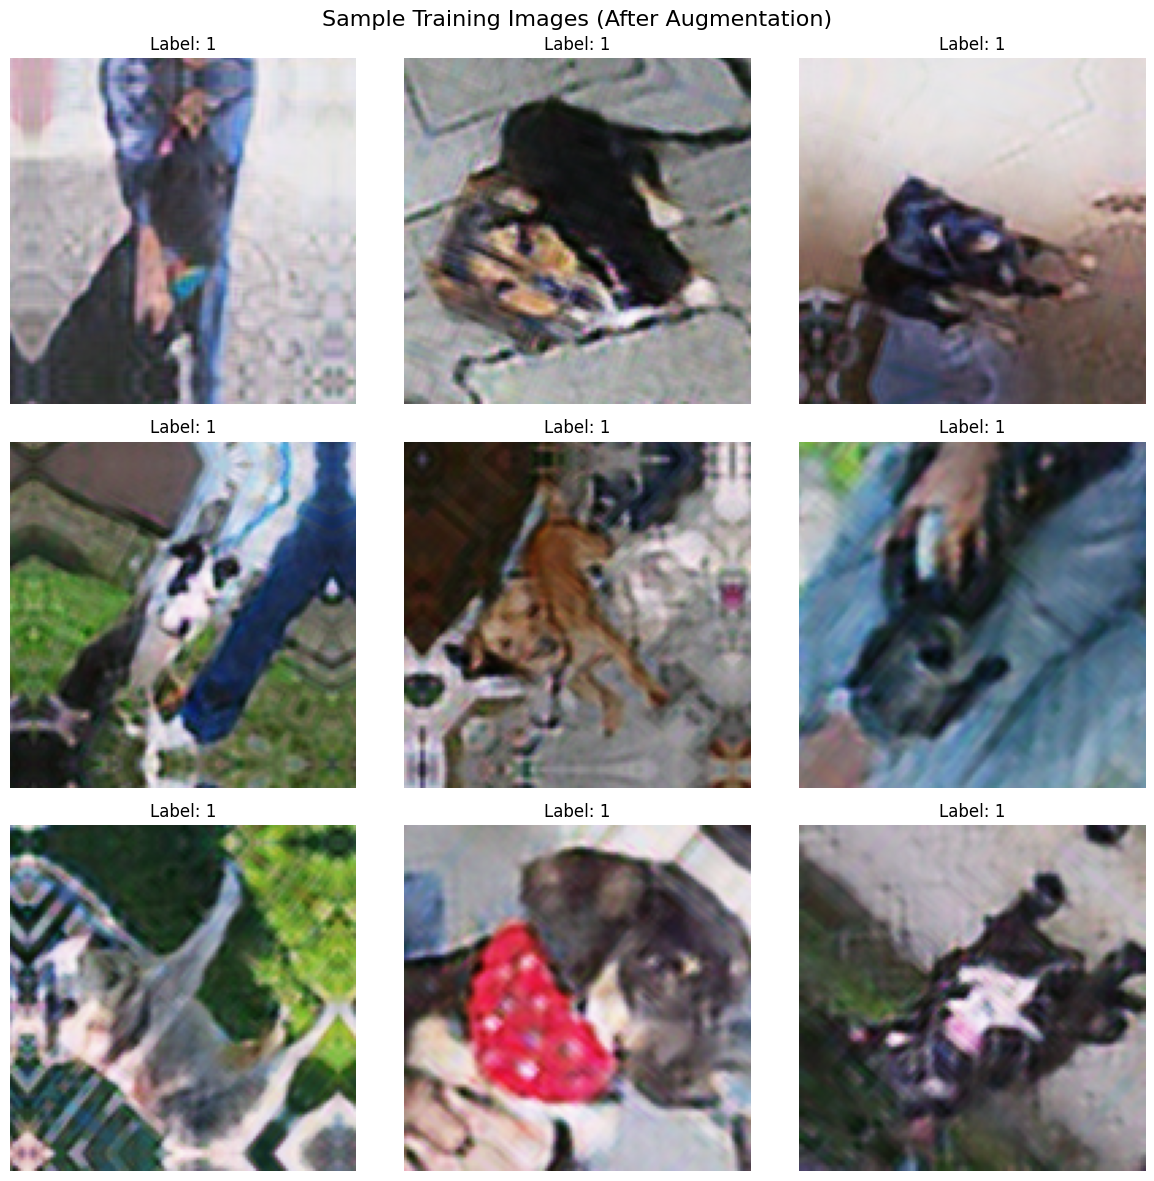

Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 61s 956ms/step - accuracy: 0.8284 - loss: 0.3538 - val_accuracy: 1.0000 - val_loss: 1.1921e-07
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 1.0000 - loss: 1.1921e-07 - val_accuracy: 1.0000 - val_loss: 1.1921e-07
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 183ms/step - accuracy: 1.0000 - loss: 1.1921e-07 - val_accuracy: 1.0000 - val_loss: 1.1921e-07
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 185ms/step - accuracy: 1.0000 - loss: 1.1921e-07 - val_accuracy: 1.0000 - val_loss: 1.1921e-07
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 183ms/step - accuracy: 1.0000 - loss: 1.1921e-07 - val_accuracy: 1.0000 - val_loss: 1.1921e-07
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 1.0000 - loss: 1.1921e-07 - val_accuracy: 1.0000 - val_loss: 1.1921e-07
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 182ms/step - accuracy: 1.0000 - loss: 1.1921e-07 - val_accuracy: 1.0000 - val_loss: 1.1921e-07
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 184ms/step

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 4 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 0 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [19]:
print("Training Model B (SR-Generated Images)...")
# Model A is the base for Model B's architecture
classifier_b = build_classifier_a() # Using build_classifier_a for architecture

train_b = tf.keras.preprocessing.image_dataset_from_directory(
    sr_dataset_path,
    label_mode='binary',
    image_size=HR_SHAPE[:2],
    batch_size=32,
    validation_split=0.3,
    subset='training',
    seed=123
)
val_b = tf.keras.preprocessing.image_dataset_from_directory(
    sr_dataset_path,
    label_mode='binary',
    image_size=HR_SHAPE[:2],
    batch_size=32,
    validation_split=0.3,
    subset='validation',
    seed=123
)

# Apply normalization and image transformations for Classifier B
# FIXED: Apply normalization and image transformations correctly
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Add data augmentation layers
data_augmentation = keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

# FIXED: Apply transformations correctly
def apply_augmentation(x, y):
    x = normalization_layer(x)
    x = data_augmentation(x, training=True)
    return x, y

def apply_normalization(x, y):
    x = normalization_layer(x)
    return x, y

train_b = train_b.map(apply_augmentation)
val_b = val_b.map(apply_normalization)

# FIXED: Better image display with debugging
print("\nDemonstrating transformed samples for Model B training:")

plt.figure(figsize=(12, 12))

for images, labels in train_b.take(1):

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)

        # Convert tensor to numpy for display
        img_display = tf.cast(images[i], tf.float32)
        plt.imshow(img_display)
        plt.title(f'Label: {int(labels[i])}')
        plt.axis("off")

plt.suptitle('Sample Training Images (After Augmentation)', fontsize=16)
plt.tight_layout()
plt.show()


classifier_b.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_b = classifier_b.fit(
    train_b,
    validation_data=val_b,
    epochs=20,
    verbose=1
)
# Define classifier_a for later use in evaluation

print("Building Model A (ResNet152V2 with custom dense head)...")

# Rebuild architecture exactly as original
image_input = Input(shape=HR_SHAPE)
base_model = keras.applications.ResNet152V2(
    input_tensor=image_input,
    include_top=False,
    weights='imagenet'
)
res_output = base_model.layers[-1].output

flat1 = Flatten()(res_output)
fc1 = Dense(512, activation='relu')(flat1)
dropfc1 = Dropout(0.5)(fc1)
fc2 = Dense(256, activation='relu')(dropfc1)
dropfc2 = Dropout(0.5)(fc2)
output = Dense(1, activation='sigmoid')(dropfc2)

# Freeze all but last 5 layers
for layer in base_model.layers[:-5]:
    layer.trainable = False

classifier_a = Model(inputs=image_input, outputs=output)
classifier_a.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Try loading weights
model_a_weights_path = '/content/drive/MyDrive/midterm/models/res_early_stop_model.weights.h5'
if os.path.exists(model_a_weights_path):
    try:
        classifier_a.load_weights(model_a_weights_path)
        print(f"✓ Successfully loaded weights from {model_a_weights_path}")
    except Exception as e:
        print(f"⚠️ Error loading weights: {e}")
        print("Retrying with by_name=True, skip_mismatch=True...")
        try:
            classifier_a.load_weights(model_a_weights_path, by_name=True, skip_mismatch=True)
            print("✓ Partial weights loaded successfully.")
        except Exception as e2:
            print("❌ Still failed:", e2)
else:
    print(f"⚠️ Model A weights file not found at {model_a_weights_path}")

# Make history_a and history_b available for plotting
if 'history_a' not in globals():
  history_a = None
if 'history_b' not in globals():
  history_b = None

Found 3036 files belonging to 2 classes.
95/95 ━━━━━━━━━━━━━━━━━━━━ 26s 167ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 21s 120ms/step

Model Comparison:
         Accuracy  F1-Score       AUC
Model A  0.941370  0.941754  0.986333
Model B  0.502964  0.669297  0.500000


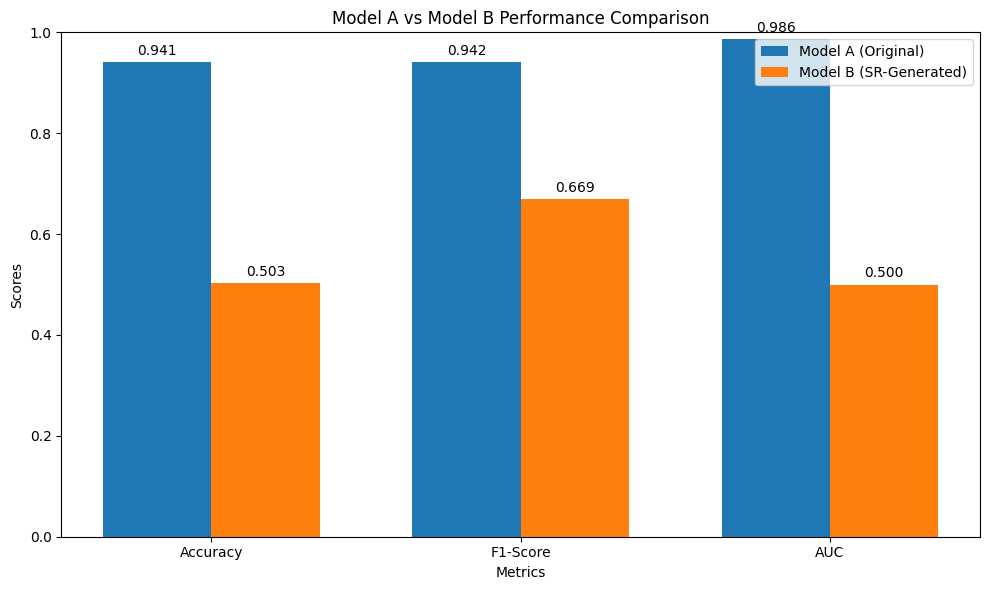

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
def evaluate_models(model_a, model_b, test_dataset):
    """Compare both models using multiple metrics"""

    # Prepare test data
    test_images, test_labels = [], []
    for images, labels in test_dataset:
        test_images.extend(images.numpy())
        test_labels.extend(labels.numpy())

    test_images = np.array(test_images)
    test_labels = np.array(test_labels)

    # Predictions
    # Ensure inputs are scaled correctly for the classifiers if they expect [0,1]
    pred_a = model_a.predict(test_images)
    pred_b = model_b.predict(test_images)

    # Convert probabilities to binary predictions
    pred_a_binary = (pred_a > 0.5).astype(int).flatten()
    pred_b_binary = (pred_b > 0.5).astype(int).flatten()

    # Calculate metrics
    from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

    metrics = {
        'Model A': {
            'Accuracy': accuracy_score(test_labels, pred_a_binary),
            'F1-Score': f1_score(test_labels, pred_a_binary),
            'AUC': roc_auc_score(test_labels, pred_a),
        },
        'Model B': {
            'Accuracy': accuracy_score(test_labels, pred_b_binary),
            'F1-Score': f1_score(test_labels, pred_b_binary),
            'AUC': roc_auc_score(test_labels, pred_b),
        }
    }

    # Create comparison table
    comparison_df = pd.DataFrame(metrics).T
    print("\nModel Comparison:")
    print(comparison_df)

    # Plot metrics comparison
    metrics_to_plot = ['Accuracy', 'F1-Score', 'AUC']
    x = np.arange(len(metrics_to_plot))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    bars1 = ax.bar(x - width/2, [metrics['Model A'][m] for m in metrics_to_plot],
                   width, label='Model A (Original)')
    bars2 = ax.bar(x + width/2, [metrics['Model B'][m] for m in metrics_to_plot],
                   width, label='Model B (SR-Generated)')

    ax.set_xlabel('Metrics')
    ax.set_ylabel('Scores')
    ax.set_title('Model A vs Model B Performance Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics_to_plot)
    ax.legend()
    ax.set_ylim(0, 1)

    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.3f}',
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    return metrics

# Perform evaluation
test_ds_eval = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/midterm/data/test/', # Use DATA_ROOT
    label_mode='binary',
    image_size=HR_SHAPE[:2],
    batch_size=32,
    shuffle=False
)

# Rescale for evaluation
rescale_eval = tf.keras.layers.Rescaling(1./255)
test_ds_eval = test_ds_eval.map(lambda x, y: (rescale_eval(x), y))

# Check if classifier_a and classifier_b are defined and trained
if 'classifier_a' in globals() and 'classifier_b' in globals() and classifier_a is not None and classifier_b is not None:
    metrics_results = evaluate_models(classifier_a, classifier_b, test_ds_eval)
else:
    print("Classifier models (classifier_a, classifier_b) are not defined or not trained. Skipping evaluation.")

In [ ]:
import matplotlib.pyplot as plt

def visualize_sr_results(generator, num_samples=5):
    """Visualize original low-res, super-resolved, and original high-res images"""

    # Get sample pairs from test_ds, which yields (HR, LR)
    for hr_imgs, lr_imgs in test_ds.take(1):
        # Generate SR images from the LR samples
        sr_imgs = generator.predict(lr_imgs[:num_samples])

        plt.figure(figsize=(15, 4*num_samples))
        for i in range(num_samples):
            # Low-res input (normalize from [-1,1] to [0,1] for display)
            plt.subplot(num_samples, 3, i*3 + 1)
            plt.imshow((lr_imgs[i].numpy() + 1) / 2)
            plt.title(f'Low-res Input\n32x32')
            plt.axis('off')

            # Super-resolved output (normalize from [-1,1] to [0,1] for display)
            plt.subplot(num_samples, 3, i*3 + 2)
            plt.imshow((sr_imgs[i] + 1) / 2)
            plt.title(f'Super-resolved\n128x128')
            plt.axis('off')

            # Original high-res (normalize from [-1,1] to [0,1] for display)
            plt.subplot(num_samples, 3, i*3 + 3)
            plt.imshow((hr_imgs[i].numpy() + 1) / 2)
            plt.title(f'Original High-res\n128x128')
            plt.axis('off')

        plt.tight_layout()
        plt.show()
        break

# Show SR results only if srgan_model and its generator exist
if srgan_model is not None and srgan_model.generator is not None:
    visualize_sr_results(srgan_model.generator)
else:
    print("SRGAN model or its generator is not available for visualization.")

# Plot training history
def plot_training_history(history_gan, history_a_classifier, history_b_classifier):
    plt.figure(figsize=(12, 4))

    if history_gan is not None:
        plt.subplot(1, 2, 1)
        plt.plot(history_gan.history['discriminator_loss'], label='Discriminator Loss')
        plt.plot(history_gan.history['generator_loss'], label='Generator Loss')
        plt.title('SRGAN Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
    else:
        plt.subplot(1, 2, 1)
        plt.text(0.5, 0.5, 'SRGAN History Not Available', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

    plt.subplot(1, 2, 2)
    if history_a_classifier is not None:
        plt.plot(history_a_classifier.history['val_accuracy'], label='Model A (Original HR)')
    if history_b_classifier is not None:
        plt.plot(history_b_classifier.history['val_accuracy'], label='Model B (SR-Generated HR)')
    plt.title('Classifier Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    if history_a_classifier is None and history_b_classifier is None:
        plt.text(0.5, 0.5, 'Classifier Histories Not Available', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

    plt.tight_layout()
    plt.show()

# Call the plotting function with the relevant history objects
# Ensure history, history_a, and history_b are defined from training runs
plot_training_history(history, history_a, history_b)

In [ ]:
import matplotlib.pyplot as plt

def visualize_sr_results(generator, num_samples=5):
    """Visualize original low-res, super-resolved, and original high-res images"""

    print("🔍 Starting visualization...")

    # Check if test_ds exists and get one batch
    if 'test_ds' not in globals() or test_ds is None:
        print("❌ test_ds is not defined")
        return

    try:
        # Get one batch - use explicit iteration
        iterator = iter(test_ds)
        batch = next(iterator)

        # Handle different dataset formats
        if isinstance(batch, tuple) and len(batch) == 2:
            hr_imgs, lr_imgs = batch
            print(f"✅ Got batch - HR: {hr_imgs.shape}, LR: {lr_imgs.shape}")
        else:
            print(f"❌ Unexpected batch format: {type(batch)}")
            return

        # Ensure we have enough samples
        actual_samples = min(num_samples, hr_imgs.shape[0])
        print(f"🔄 Processing {actual_samples} samples...")

        # Take the samples we need
        lr_samples = lr_imgs[:actual_samples]
        hr_samples = hr_imgs[:actual_samples]

        # Generate SR images
        print("🔄 Generating super-resolved images...")
        sr_imgs = generator.predict(lr_samples, verbose=1)
        print(f"✅ Generated SR images: {sr_imgs.shape}")

        # Create the visualization
        create_visualization(lr_samples, sr_imgs, hr_samples, actual_samples)

    except StopIteration:
        print("❌ test_ds is empty")
    except Exception as e:
        print(f"❌ Error during visualization: {e}")
        print(f"Error type: {type(e).__name__}")

def create_visualization(lr_imgs, sr_imgs, hr_imgs, num_samples):
    """Create the actual visualization plot"""
    plt.figure(figsize=(15, 4 * num_samples))

    for i in range(num_samples):
        # Convert tensors to numpy for display
        if hasattr(lr_imgs[i], 'numpy'):
            lr_img = lr_imgs[i].numpy()
        else:
            lr_img = lr_imgs[i]

        if hasattr(hr_imgs[i], 'numpy'):
            hr_img = hr_imgs[i].numpy()
        else:
            hr_img = hr_imgs[i]

        sr_img = sr_imgs[i]

        # Low-res input (normalize from [-1,1] to [0,1] for display)
        plt.subplot(num_samples, 3, i*3 + 1)
        lr_display = (lr_img + 1) / 2
        plt.imshow(np.clip(lr_display, 0, 1))
        plt.title(f'Low-res Input\n{lr_img.shape[:2]}')
        plt.axis('off')

        # Super-resolved output (normalize from [-1,1] to [0,1] for display)
        plt.subplot(num_samples, 3, i*3 + 2)
        sr_display = (sr_img + 1) / 2
        plt.imshow(np.clip(sr_display, 0, 1))
        plt.title(f'Super-resolved\n{sr_img.shape[:2]}')
        plt.axis('off')

        # Original high-res (normalize from [-1,1] to [0,1] for display)
        plt.subplot(num_samples, 3, i*3 + 3)
        hr_display = (hr_img + 1) / 2
        plt.imshow(np.clip(hr_display, 0, 1))
        plt.title(f'Original High-res\n{hr_img.shape[:2]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    print("✅ Visualization completed!")

# Alternative: Debug your test_ds first
def debug_test_ds():
    """Debug the test_ds to understand its structure"""
    print("🔍 Debugging test_ds...")

    if 'test_ds' not in globals() or test_ds is None:
        print("❌ test_ds is not defined")
        return

    try:
        # Check dataset properties
        print(f"test_ds type: {type(test_ds)}")

        # Get one element to inspect
        iterator = iter(test_ds)
        batch = next(iterator)
        print(f"Batch type: {type(batch)}")

        if isinstance(batch, tuple):
            print(f"Batch length: {len(batch)}")
            for i, item in enumerate(batch):
                print(f"  Item {i} type: {type(item)}")
                if hasattr(item, 'shape'):
                    print(f"  Item {i} shape: {item.shape}")
                else:
                    print(f"  Item {i}: {item}")
        else:
            print(f"Batch shape: {batch.shape if hasattr(batch, 'shape') else 'No shape'}")

    except Exception as e:
        print(f"❌ Error debugging test_ds: {e}")

# Run debug first
debug_test_ds()

# Then try visualization
if srgan_model is not None and srgan_model.generator is not None:
    print("\n🔄 Attempting visualization...")
    visualize_sr_results(srgan_model.generator, num_samples=3)
else:
    print("❌ SRGAN model or its generator is not available for visualization.")